In [1]:
import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP
from besos.parameters import RangeParameter, FieldSelector, FilterSelector, Parameter, expand_plist, wwr, CategoryParameter, GenericSelector
from besos.problem import EPProblem
import pandas as pd
import numpy as np

In [2]:
output_dir = './opt_out'
epw_file = '../weather/Torre_Pellice-hour.epw'
# Define the list of idf files with different glazing type setting and set each type to a int flag
idf_files = ['../IDF/double_f.idf']
idf_flags = [2]

In [3]:
# Load idf files defined in the list
buildings = []
for file in idf_files:
    buildings.append(ef.get_building(file))

In [4]:
# [materials.Name for materials in building.idfobjects['WindowShadingControl']]# get a list of the Name property of all IDF objects of class MATERIAL
# for materials in building.idfobjects["WindowShadingControl"]:
#     if materials.Name =='1001-MainXground:Zone1':
#         print(materials)

In [5]:
# Define the fields to optimaize
insulation = FieldSelector(class_name='Material',\
                           object_name='XPS Extruded Polystyrene  - CO2 Blowing_.0795',\
                           field_name='Thickness')
ach = FieldSelector(class_name='ZoneVentilation:DesignFlowRate',\
                            object_name='*',\
                            field_name='Air Changes per Hour')
shading_temp = FieldSelector(class_name='WindowShadingControl',\
                                object_name='*',\
                                field_name='Setpoint')
shading_irradiation = FieldSelector(class_name='WindowShadingControl',\
                                object_name='*',\
                                field_name='Setpoint 2')

In [6]:
#Define the values for each field
# test_param = "Insulation Thickness"
# insulation_options=[0.05,0.1,0.15,0.2,0.25,0.35]
# ach_options = [6]
# shading_temp_options = [24]
# shading_irradiation_options=[120]

# test_param = "ACH"
# insulation_options=[0.35]
# ach_options = [0,2,4,6]
# shading_temp_options = [24]
# shading_irradiation_options=[120]

test_param = "shading temperature"
insulation_options=[0.35]
ach_options = [6]
shading_temp_options = [18,20,22,24,26,28,100]
shading_irradiation_options=[120]

# test_param = "shading irradiation"
# insulation_options=[0.35]
# ach_options = [6]
# shading_temp_options = [24]
# shading_irradiation_options=[80,120,160,200,240,280,320]

insulation_range = CategoryParameter(options=insulation_options)
ach_choice = CategoryParameter(options=ach_options)
shading_temp_range=CategoryParameter(options=shading_temp_options)
shading_irradiation_range=CategoryParameter(options=shading_irradiation_options)


In [7]:
# Define the params according to fields and field valuse
insulation_param = Parameter(selector=insulation,
                            value_descriptors=[insulation_range],
                            name='Insulation Thickness')
ach_param = Parameter(selector=ach,
                            value_descriptors=[ach_choice],
                            name='ACH')
shading_temp_param = Parameter(selector=shading_temp,
                            value_descriptors=[shading_temp_range],
                            name='shading temperature')
shading_irradiation_param =Parameter(selector=shading_irradiation,
                            value_descriptors=[shading_irradiation_range],
                            name='shading irradiation')

parameters = [insulation_param,ach_param,shading_temp_param,shading_irradiation_param] 

In [8]:
# Define the objectives and the problem
objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility'] # these get made into `MeterReader` or `VariableReader`
problem=EPProblem(parameters, objectives) # problem = parameters + objectives
problem

EPProblem(inputs=[Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='XPS Extruded Polystyrene  - CO2 Blowing_.0795'), value_descriptors=[CategoryParameter(options=[0.35])]), Parameter(selector=FieldSelector(field_name='Air Changes per Hour', class_name='ZoneVentilation:DesignFlowRate', object_name='*'), value_descriptors=[CategoryParameter(options=[6])]), Parameter(selector=FieldSelector(field_name='Setpoint', class_name='WindowShadingControl', object_name='*'), value_descriptors=[CategoryParameter(options=[18, 20, 22, 24, 26, 28, 100])]), Parameter(selector=FieldSelector(field_name='Setpoint 2', class_name='WindowShadingControl', object_name='*'), value_descriptors=[CategoryParameter(options=[120])])], outputs=[MeterReader(class_name='Output:Meter', func=<function sum_values at 0x7f8ce4f3f550>, key_name='Electricity:Facility'), MeterReader(class_name='Output:Meter', func=<function sum_values at 0x7f8ce4f3f550>, key_name='DistrictHeating:Facili

In [9]:
# Create the samples (each idf with different glazing setting will run accross these samples)
# samples = sampling.dist_sampler(sampling.lhs, problem, num_samples=2)
# samples
samples_raw = []
for i_o in insulation_options:
    for a_o in ach_options:
        for s_t_o in shading_temp_options:
            for s_i_o in shading_irradiation_options:
                samples_raw.append([i_o,a_o,s_t_o,s_i_o])
samples = pd.DataFrame(np.array(samples_raw),columns=['Insulation Thickness','ACH','shading temperature','shading irradiation'])
samples

,Insulation Thickness,ACH,shading temperature,shading irradiation
0,0.35,6.0,18.0,120.0
1,0.35,6.0,20.0,120.0
2,0.35,6.0,22.0,120.0
3,0.35,6.0,24.0,120.0
4,0.35,6.0,26.0,120.0
5,0.35,6.0,28.0,120.0
6,0.35,6.0,100.0,120.0


In [10]:
# Evaluate the probem with different idfs and collect the results
results = []
for i in range(len(buildings)):
    evaluator = EvaluatorEP(problem, buildings[i], out_dir=output_dir, err_dir=output_dir ,epw=epw_file) # evaluator = problem + building
    output = evaluator.df_apply(samples, keep_input=True)
    results.append(output)

Executing:   0%|          | 0/7 [00:00<?, ?row/s]

EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.15 21:42
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.15 21:42
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.15 21:43
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.15 21:43
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.15 21:44
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.15 21:44
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.15 21:44
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Constructi

EnergyPlus Completed Successfully.


In [11]:
dataframes = []
for i in range(len(results)):
    df = results[i]
    df['glazing layers']=idf_flags[i]
    dataframes.append(df)
#     final_result.append(df,ignore_index=True)
merged_result = pd.concat(dataframes,ignore_index=True)
electricity = merged_result["Electricity:Facility"]
electricity = electricity/3.6e6
merged_result["Electricity:Facility"]=electricity
heating = merged_result["DistrictHeating:Facility"]
heating = heating/3.6e6
merged_result["DistrictHeating:Facility"]=heating
cooling = merged_result["DistrictCooling:Facility"]
cooling = cooling/3.6e6
merged_result["DistrictCooling:Facility"]=cooling
merged_result=merged_result.reindex(columns=["Insulation Thickness","ACH","shading temperature","shading irradiation","glazing layers","Electricity:Facility","DistrictHeating:Facility","DistrictCooling:Facility"])

In [12]:
merged_result

,Insulation Thickness,ACH,shading temperature,shading irradiation,glazing layers,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
0,0.35,6.0,18.0,120.0,2,2498.670456,6949.876926,677.733925
1,0.35,6.0,20.0,120.0,2,2468.724866,6932.032765,902.051857
2,0.35,6.0,22.0,120.0,2,2429.112512,6916.964373,1188.884957
3,0.35,6.0,24.0,120.0,2,2395.394814,6912.429593,1506.903114
4,0.35,6.0,26.0,120.0,2,2369.130499,6912.385169,1751.753882
5,0.35,6.0,28.0,120.0,2,2340.037758,6912.336217,1992.158066
6,0.35,6.0,100.0,120.0,2,2322.276614,6912.317605,2138.718113


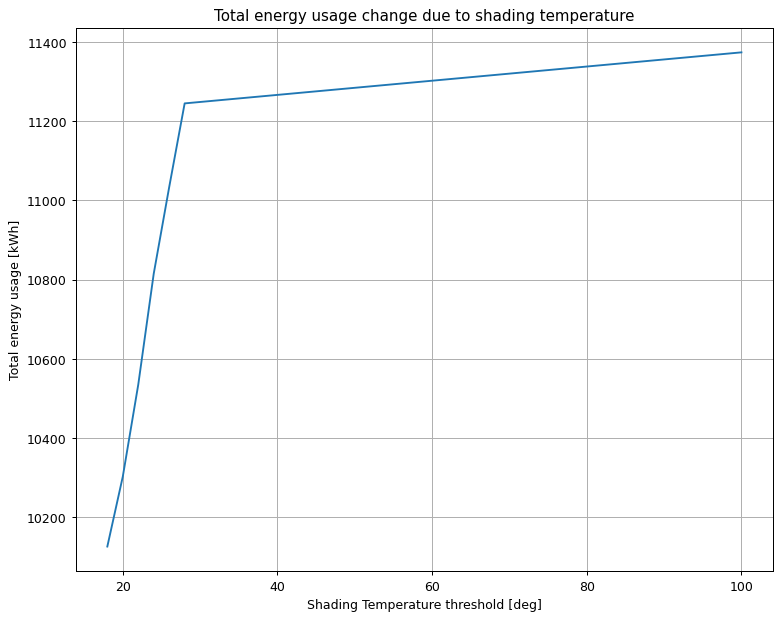

In [13]:
plt.figure(figsize=(10,8), dpi=90)
plt.plot(results[0][test_param],results[0]["Electricity:Facility"]/3.6e6+results[0]["DistrictCooling:Facility"]/3.6e6+results[0]["DistrictHeating:Facility"]/3.6e6)
plt.title("Total energy usage change due to "+test_param)
plt.grid()
plt.ylabel("Total energy usage [kWh]")

if test_param =="Insulation Thickness":
    plt.xlabel("Insulation Thickness [m]")
elif test_param =="ACH":
    plt.xlabel("ACH")
elif test_param=="shading temperature":
    plt.xlabel("Shading Temperature threshold [deg]")
elif test_param=="shading irradiation":
    plt.xlabel("Shading irradiation threshold[W/m^2]")
else:
    raise ValueError


# plt.savefig("./figures/"+test_param+"_total.png")

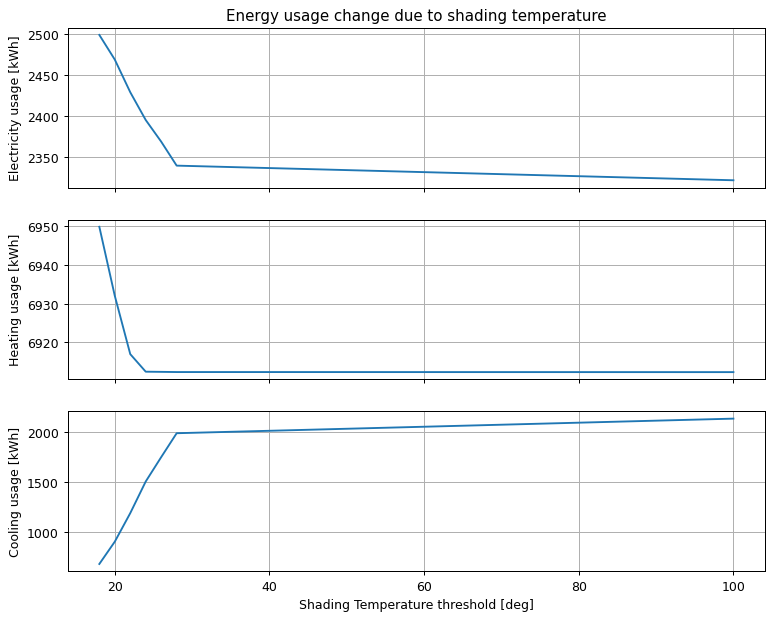

In [14]:

fig, ax = plt.subplots(nrows=3, ncols=1,sharex=True,figsize=(10,8), dpi=90)
ax[0].set_title("Energy usage change due to "+test_param)
ax[0].plot(results[0][test_param],results[0]["Electricity:Facility"]/3.6e6)
ax[0].grid()
ax[0].set_ylabel("Electricity usage [kWh]")

if test_param=="shading irradiation":
    temp_int = []
    temp =results[0]["DistrictHeating:Facility"]/3.6e6
    temp = temp.to_list()
    for elem in temp:
        temp_int.append(int(elem))
    ax[1].plot(results[0][test_param],temp_int)
else:
    ax[1].plot(results[0][test_param],results[0]["DistrictHeating:Facility"]/3.6e6)
ax[1].grid()
ax[1].set_ylabel("Heating usage [kWh]")

ax[2].plot(results[0][test_param],results[0]["DistrictCooling:Facility"]/3.6e6)
ax[2].grid()
ax[2].set_ylabel("Cooling usage [kWh]")

if test_param =="Insulation Thickness":
    ax[2].set_xlabel("Insulation Thickness [m]")
elif test_param =="ACH":
    ax[2].set_xlabel("ACH")
elif test_param=="shading temperature":
    ax[2].set_xlabel("Shading Temperature threshold [deg]")
elif test_param=="shading irradiation":
    ax[2].set_xlabel("Shading irradiation threshold[W/m^2]")
else:
    raise ValueError

# fig.savefig("./figures/"+test_param+".png")

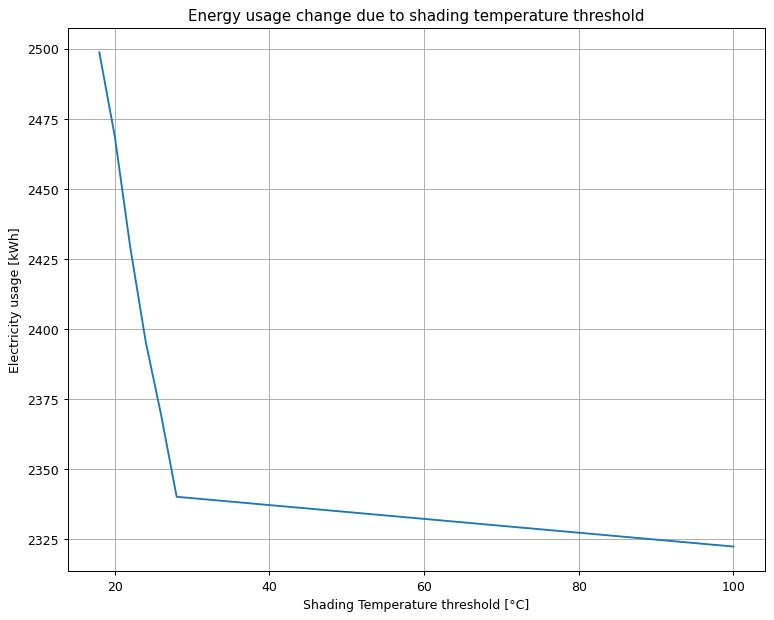

In [15]:
plt.figure(figsize=(10,8), dpi=90)
plt.plot(results[0][test_param],results[0]["Electricity:Facility"]/3.6e6)

plt.title("Energy usage change due to "+test_param+" threshold")
plt.ylabel("Electricity usage [kWh]")
if test_param =="Insulation Thickness":
    plt.xlabel("Insulation Thickness [m]")
elif test_param =="ACH":
    plt.xlabel("ACH")
elif test_param=="shading temperature":
    plt.xlabel("Shading Temperature threshold [°C]")
elif test_param=="shading irradiation":
    plt.xlabel("Shading irradiation threshold[W/m^2]")
else:
    raise ValueError
plt.grid()
# plt.savefig("./figures/shading_temp_electricity.png")